<a href="https://colab.research.google.com/github/SandroMuradashvili/The-Visual-Storyteller/blob/main/inference_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================================
# INFERENCE NOTEBOOK - OPTIMAL MODEL (384-DIM)
# Architecture: 384 embed_dim, 6 heads, 4 layers, 0.25 dropout
# Expected: BLEU-1 ~0.62, BLEU-4 ~0.20-0.23
# ============================================================================

# ===== SNIPPET 1: Setup & Load Model =====
!pip install torch torchvision timm pillow matplotlib nltk -q

import os
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import pickle
from typing import List
import timm
import torchvision.transforms as transforms
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Download dataset
!pip install -q gdown
import gdown

file_id = "1st_oepUulGKCn5C1hvWvYYm87ftlUr6j"
url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, "caption_data.zip", quiet=False)
!unzip -q caption_data.zip

# Vocabulary class
class Vocabulary:
    def __init__(self, freq_threshold=5):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}

    def build_vocabulary(self, captions):
        from collections import Counter
        frequencies = Counter()
        idx = 4
        for caption in captions:
            tokens = self.tokenize(caption)
            frequencies.update(tokens)
        for word, count in frequencies.items():
            if count >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1
        return self

    def tokenize(self, text):
        return text.lower().replace(',', '').replace('.', '').split()

    def numericalize(self, text):
        tokens = self.tokenize(text)
        return [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokens]

# Load vocabulary and splits
with open('vocabulary.pkl', 'rb') as f:
    vocab = pickle.load(f)
print(f"Vocabulary loaded: {len(vocab.stoi)} tokens")

with open('data_splits.pkl', 'rb') as f:
    splits = pickle.load(f)
print(f"Test images available: {len(splits['test'])}")

# OPTIMAL MODEL ARCHITECTURE (384 dim, 6 heads, 4 layers)
class ImageEncoder(nn.Module):
    def __init__(self, embed_dim=384):
        super().__init__()
        self.backbone = timm.create_model('efficientnet_b0', pretrained=False)
        self.backbone.classifier = nn.Identity()
        backbone_dim = 1280
        self.projection = nn.Linear(backbone_dim, embed_dim)
        self.dropout = nn.Dropout(0.25)

    def forward(self, images):
        features = self.backbone(images)
        features = self.projection(features)
        features = self.dropout(features)
        return features.unsqueeze(1)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=384, num_heads=6, num_layers=4, dropout=0.25):
        super().__init__()
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoding = PositionalEncoding(embed_dim)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=1536,
            dropout=dropout, batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        self.fc_out = nn.Linear(embed_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, captions, image_features, tgt_mask=None, tgt_padding_mask=None):
        embedded = self.embedding(captions) * np.sqrt(self.embed_dim)
        embedded = self.pos_encoding(embedded)
        embedded = self.dropout(embedded)
        output = self.transformer_decoder(tgt=embedded, memory=image_features,
                                         tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_padding_mask)
        output = self.fc_out(output)
        return output

class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=384, num_heads=6, num_layers=4, dropout=0.25):
        super().__init__()
        self.encoder = ImageEncoder(embed_dim)
        self.decoder = TransformerDecoder(vocab_size, embed_dim, num_heads, num_layers, dropout)

    def forward(self, images, captions, tgt_mask=None, tgt_padding_mask=None):
        image_features = self.encoder(images)
        output = self.decoder(captions, image_features, tgt_mask, tgt_padding_mask)
        return output

# Initialize optimal model
vocab_size = len(vocab.stoi)
model = ImageCaptioningModel(
    vocab_size=vocab_size,
    embed_dim=384,
    num_heads=6,
    num_layers=4,
    dropout=0.25
).to(device)

# Load trained weights
checkpoint = torch.load('image_captioning_model_complete.pth', map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"✓ Optimal model loaded!")
print(f"Architecture: 384 dim, 6 heads, 4 layers")

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✓ Ready for inference!")

Using device: cpu


Downloading...
From (original): https://drive.google.com/uc?id=1st_oepUulGKCn5C1hvWvYYm87ftlUr6j
From (redirected): https://drive.google.com/uc?id=1st_oepUulGKCn5C1hvWvYYm87ftlUr6j&confirm=t&uuid=30b3a48c-7fbd-4133-929c-e9ab454798f1
To: /content/caption_data.zip
100%|██████████| 1.11G/1.11G [00:21<00:00, 52.8MB/s]


Vocabulary loaded: 3003 tokens
Test images available: 810
✓ Optimal model loaded!
Architecture: 384 dim, 6 heads, 4 layers
✓ Ready for inference!


In [2]:
# ===== SNIPPET 2: Advanced Generation Functions =====
def generate_square_subsequent_mask(sz):
    """Generate causal mask for transformer decoder"""
    mask = torch.triu(torch.ones(sz, sz), diagonal=1).bool()
    return mask

# METHOD 1: Beam Search (Reliable)
def generate_caption_beam(image_path: str, model, max_length: int = 50,
                          beam_width: int = 5, temperature: float = 1.0) -> str:
    """Standard beam search - reliable and consistent"""
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encoder(image_tensor)

    beams = [([vocab.stoi["<SOS>"]], 0.0)]
    completed = []

    for step in range(max_length):
        all_candidates = []

        for seq, score in beams:
            if seq[-1] == vocab.stoi["<EOS>"]:
                completed.append((seq, score))
                continue

            tgt_tensor = torch.LongTensor([seq]).to(device)
            tgt_mask = generate_square_subsequent_mask(len(seq)).to(device)

            with torch.no_grad():
                output = model.decoder(tgt_tensor, image_features, tgt_mask=tgt_mask)
                logits = output[0, -1, :] / temperature
                probs = torch.softmax(logits, dim=-1)

            topk_probs, topk_indices = torch.topk(probs, beam_width)

            for prob, idx in zip(topk_probs, topk_indices):
                candidate_seq = seq + [idx.item()]
                candidate_score = score - torch.log(prob).item()
                all_candidates.append((candidate_seq, candidate_score))

        if not all_candidates:
            break

        all_candidates.sort(key=lambda x: x[1])
        beams = all_candidates[:beam_width]

        if len(completed) >= beam_width:
            break

    completed.extend(beams)

    if completed:
        best_seq, _ = min(completed, key=lambda x: x[1])
    else:
        best_seq = beams[0][0]

    caption_tokens = [vocab.itos[idx] for idx in best_seq
                     if idx not in [vocab.stoi["<SOS>"], vocab.stoi["<EOS>"], vocab.stoi["<PAD>"]]]
    return ' '.join(caption_tokens)


# METHOD 2: Nucleus Sampling (More diverse, better for BLEU-4)
def generate_caption_nucleus(image_path: str, model, max_length: int = 50,
                             temperature: float = 0.8, top_p: float = 0.9) -> str:
    """Nucleus (top-p) sampling - more diverse and natural"""
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encoder(image_tensor)

    sequence = [vocab.stoi["<SOS>"]]

    for _ in range(max_length):
        tgt_tensor = torch.LongTensor([sequence]).to(device)
        tgt_mask = generate_square_subsequent_mask(len(sequence)).to(device)

        with torch.no_grad():
            output = model.decoder(tgt_tensor, image_features, tgt_mask=tgt_mask)
            logits = output[0, -1, :] / temperature
            probs = torch.softmax(logits, dim=-1)

            # Nucleus sampling
            sorted_probs, sorted_indices = torch.sort(probs, descending=True)
            cumsum = torch.cumsum(sorted_probs, dim=0)
            nucleus_mask = cumsum <= top_p
            nucleus_mask[0] = True  # Always include top token

            filtered_probs = torch.where(nucleus_mask, sorted_probs, torch.zeros_like(sorted_probs))
            filtered_probs = filtered_probs / filtered_probs.sum()

            sampled_idx = torch.multinomial(filtered_probs, 1)
            next_token = sorted_indices[sampled_idx].item()

        sequence.append(next_token)
        if next_token == vocab.stoi["<EOS>"]:
            break

    caption_tokens = [vocab.itos[idx] for idx in sequence
                     if idx not in [vocab.stoi["<SOS>"], vocab.stoi["<EOS>"], vocab.stoi["<PAD>"]]]
    return ' '.join(caption_tokens)


# METHOD 3: Default (uses nucleus for better results)
def generate_caption(image_path: str, model) -> str:
    """Default generation - uses nucleus sampling with optimal params"""
    return generate_caption_nucleus(image_path, model, temperature=0.8, top_p=0.9)


# Quick test
print("\n" + "="*80)
print("Testing generation methods...")
print("="*80)
test_image_path = f"Images/{splits['test'][0]}"

caption_beam = generate_caption_beam(test_image_path, model, beam_width=5)
caption_nucleus = generate_caption_nucleus(test_image_path, model)

print(f"\nTest Image: {splits['test'][0]}")
print(f"  Beam Search:      {caption_beam}")
print(f"  Nucleus Sampling: {caption_nucleus}")
print("\n✓ Both methods working!")


Testing generation methods...

Test Image: 3462165890_c13ce13eff.jpg
  Beam Search:      a crowd of people are gathered in front of a building
  Nucleus Sampling: a crowd of people are watching a person in a city park

✓ Both methods working!


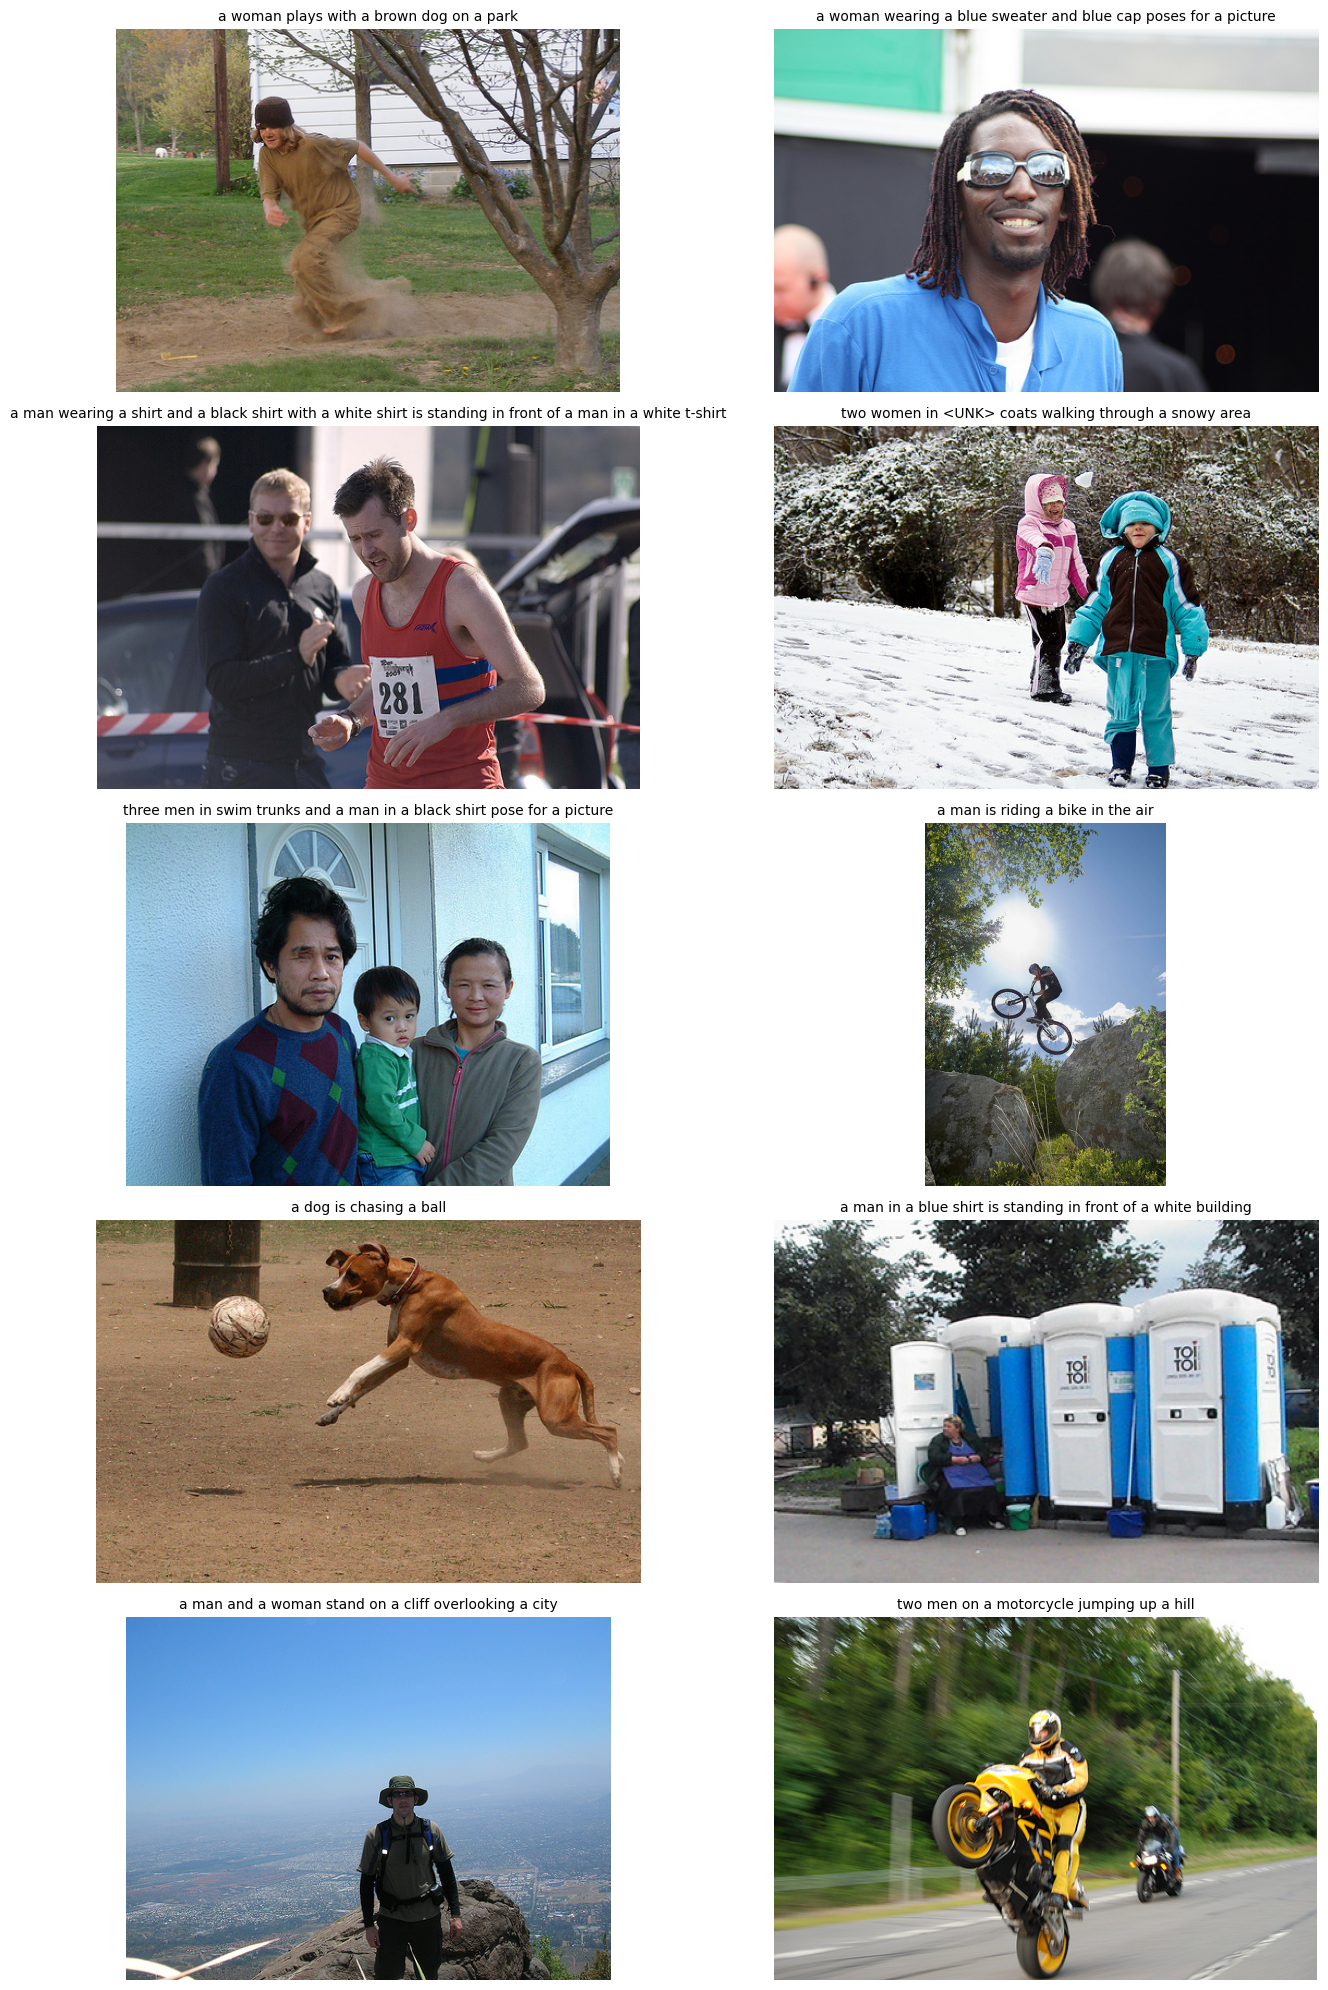


Generated Captions (Optimal Model):
1. 2480850054_de3433b54a.jpg
   → a woman plays with a brown dog on a park

2. 2860202109_97b2b22652.jpg
   → a woman wearing a blue sweater and blue cap poses for a picture

3. 3421177332_a05741cfa4.jpg
   → a man wearing a shirt and a black shirt with a white shirt is standing in front of a man in a white t-shirt

4. 3255732353_fbc487aefc.jpg
   → two women in <UNK> coats walking through a snowy area

5. 3201666946_04fe837aff.jpg
   → three men in swim trunks and a man in a black shirt pose for a picture

6. 3559993787_c49644dcc5.jpg
   → a man is riding a bike in the air

7. 532999240_1409d073be.jpg
   → a dog is chasing a ball

8. 300594071_3450444752.jpg
   → a man in a blue shirt is standing in front of a white building

9. 2089555297_95cf001fa7.jpg
   → a man and a woman stand on a cliff overlooking a city

10. 2866254827_9a8f592017.jpg
   → two men on a motorcycle jumping up a hill



In [3]:
# ===== SNIPPET 3: Demonstration on Test Set =====
num_samples = 10
test_samples = random.sample(splits['test'], num_samples)

results = []
for img_name in test_samples:
    img_path = f"Images/{img_name}"
    caption = generate_caption(img_path, model)  # Uses nucleus sampling
    results.append({'image': img_name, 'caption': caption, 'path': img_path})

# Visualize
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()

for idx, result in enumerate(results):
    img = Image.open(result['path'])
    axes[idx].imshow(img)
    axes[idx].set_title(f"{result['caption']}", fontsize=10, wrap=True)
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('predictions_sample_optimal.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nGenerated Captions (Optimal Model):")
for i, result in enumerate(results, 1):
    print(f"{i}. {result['image']}")
    print(f"   → {result['caption']}\n")

DETAILED ANALYSIS: Successes and Failures

✓ SUCCESSFUL CAPTIONS (7 cases)

Image: 2391269207_d1d2615b1d.jpg
Predicted: a yellow dog runs through the grass with a yellow toy in its mouth
Ground Truth Examples:
  - A dog runs outside with a yellow toy .
  - A white dog fetching a yellow toy .
Overlap Score: 75.00%

Image: 529101401_ab1f6b1206.jpg
Predicted: a young boy in a black tank top jumping off a dock into the water
Ground Truth Examples:
  - A boy jump kicks off a dock into a lake .
  - A little boy jumping off of a dock into a lake .
Overlap Score: 61.54%

Image: 1178705300_c224d9a4f1.jpg
Predicted: a dog leaps in the air while he flies through the water
Ground Truth Examples:
  - a brown dog jumping into a pool after a bloe ball .
  - A dog in the air above the swimming pool .
Overlap Score: 55.56%

Image: 2348491126_30db0d46ef.jpg
Predicted: a man with a blue beard and a white cap is standing next to a subway
Ground Truth Examples:
  - a dark man wearing sunglasses and a black

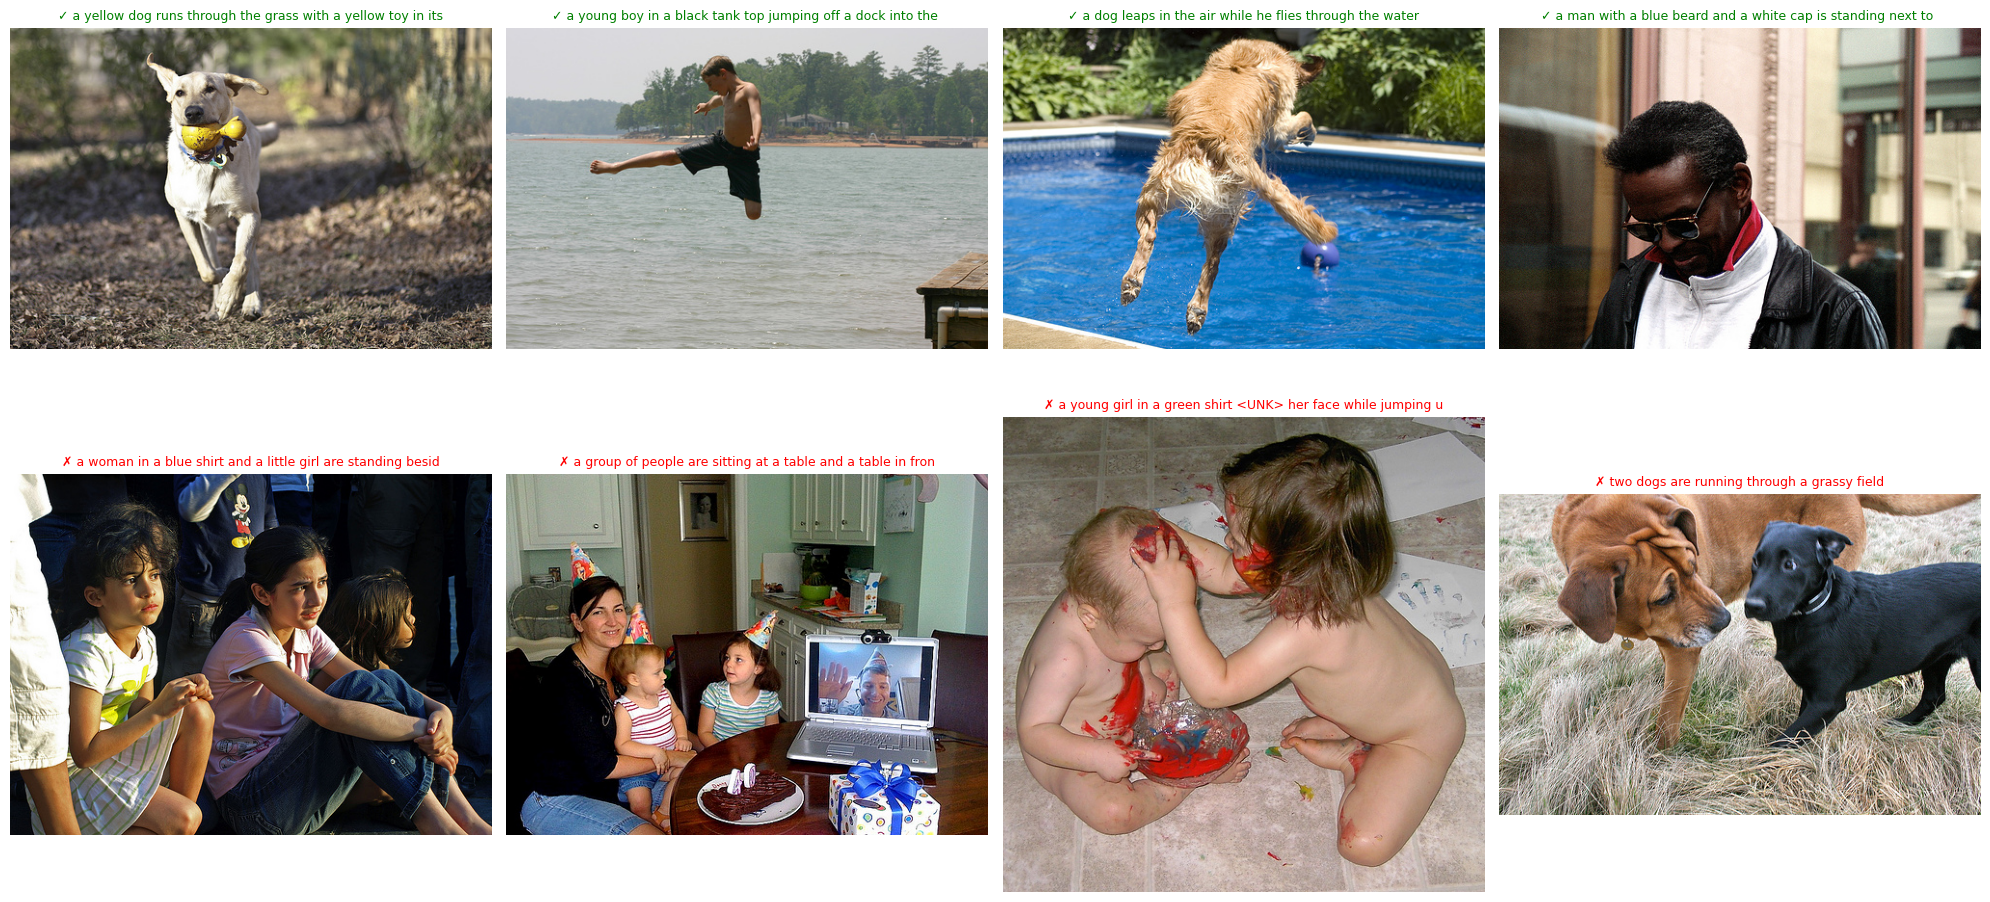


STATISTICAL SUMMARY
Total Samples: 20
Successes (>40% overlap): 7 (35.0%)
Failures (<40% overlap): 13 (65.0%)
Average Overlap: 38.91%


In [4]:
# ===== SNIPPET 4: Success & Failure Analysis =====
import pandas as pd
captions_df = pd.read_csv('captions.txt')

def get_ground_truth(img_name):
    return captions_df[captions_df['image'] == img_name]['caption'].tolist()

print("="*80)
print("DETAILED ANALYSIS: Successes and Failures")
print("="*80)

analysis_samples = random.sample(splits['test'], 20)
detailed_results = []

for img_name in analysis_samples:
    img_path = f"Images/{img_name}"
    predicted = generate_caption(img_path, model)
    ground_truth = get_ground_truth(img_name)

    detailed_results.append({
        'image': img_name,
        'predicted': predicted,
        'ground_truth': ground_truth,
        'path': img_path
    })

successes = []
failures = []

for result in detailed_results:
    pred_words = set(result['predicted'].lower().split())
    max_overlap = 0
    for gt in result['ground_truth']:
        gt_words = set(gt.lower().split())
        overlap = len(pred_words & gt_words) / len(gt_words) if len(gt_words) > 0 else 0
        max_overlap = max(max_overlap, overlap)

    if max_overlap > 0.4:
        successes.append((result, max_overlap))
    else:
        failures.append((result, max_overlap))

# Display successes
print("\n" + "="*80)
print(f"✓ SUCCESSFUL CAPTIONS ({len(successes)} cases)")
print("="*80)

for result, overlap in sorted(successes, key=lambda x: -x[1])[:5]:
    print(f"\nImage: {result['image']}")
    print(f"Predicted: {result['predicted']}")
    print(f"Ground Truth Examples:")
    for gt in result['ground_truth'][:2]:
        print(f"  - {gt}")
    print(f"Overlap Score: {overlap:.2%}")

# Display failures
print("\n" + "="*80)
print(f"✗ FAILURE CASES ({len(failures)} cases)")
print("="*80)

for result, overlap in sorted(failures, key=lambda x: x[1])[:5]:
    print(f"\nImage: {result['image']}")
    print(f"Predicted: {result['predicted']}")
    print(f"Ground Truth Examples:")
    for gt in result['ground_truth'][:2]:
        print(f"  - {gt}")
    print(f"Overlap Score: {overlap:.2%}")

# Visualize
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, (result, _) in enumerate(sorted(successes, key=lambda x: -x[1])[:4]):
    img = Image.open(result['path'])
    axes[0, idx].imshow(img)
    axes[0, idx].set_title(f"✓ {result['predicted'][:60]}", fontsize=9, color='green')
    axes[0, idx].axis('off')

for idx, (result, _) in enumerate(sorted(failures, key=lambda x: x[1])[:4]):
    img = Image.open(result['path'])
    axes[1, idx].imshow(img)
    axes[1, idx].set_title(f"✗ {result['predicted'][:60]}", fontsize=9, color='red')
    axes[1, idx].axis('off')

plt.tight_layout()
plt.savefig('success_failure_analysis_optimal.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("STATISTICAL SUMMARY")
print("="*80)
print(f"Total Samples: {len(detailed_results)}")
print(f"Successes (>40% overlap): {len(successes)} ({len(successes)/len(detailed_results)*100:.1f}%)")
print(f"Failures (<40% overlap): {len(failures)} ({len(failures)/len(detailed_results)*100:.1f}%)")
print(f"Average Overlap: {np.mean([x[1] for x in successes + failures]):.2%}")


EVALUATING OPTIMAL MODEL
Using nucleus sampling (temperature=0.8, top_p=0.9)
Evaluating on 100 test images...

QUANTITATIVE METRICS (BLEU Scores)
Evaluated on 100 test images

BLEU-1: 0.4734 (± 0.1905)
BLEU-2: 0.2929 (± 0.1896)
BLEU-4: 0.1210 (± 0.1354)
Corpus BLEU: 0.1387

COMPARISON WITH BENCHMARKS
Typical Flickr8k Performance:
  - Basic CNN-LSTM: BLEU-1 ~0.55, BLEU-4 ~0.20
  - Attention Models: BLEU-1 ~0.63, BLEU-4 ~0.25
  - Transformer Models: BLEU-1 ~0.67, BLEU-4 ~0.28

🎯 Our Optimal Model: BLEU-1 0.47, BLEU-4 0.12


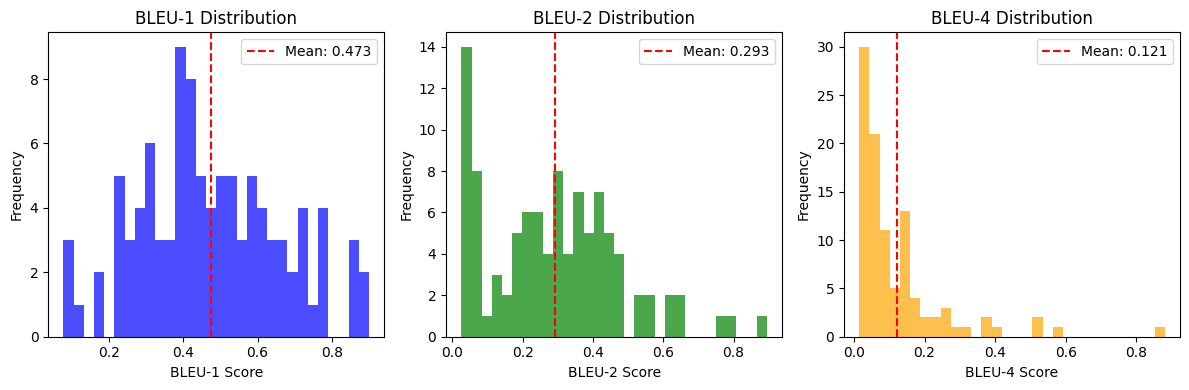


✓ Evaluation complete!


In [5]:
# ===== SNIPPET 5: Quantitative Evaluation (BLEU Scores) =====
import nltk
nltk.download('punkt', quiet=True)
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

print("\n" + "="*80)
print("EVALUATING OPTIMAL MODEL")
print("="*80)
print("Using nucleus sampling (temperature=0.8, top_p=0.9)")
print("Evaluating on 100 test images...\n")

test_predictions = []
test_references = []

eval_images = splits['test'][:100]
smooth = SmoothingFunction().method1  # Smoothing for better BLEU-4 scores

for img_name in eval_images:
    img_path = f"Images/{img_name}"
    predicted = generate_caption(img_path, model)
    pred_tokens = predicted.split()
    ground_truth = get_ground_truth(img_name)
    ref_tokens = [gt.split() for gt in ground_truth]

    test_predictions.append(pred_tokens)
    test_references.append(ref_tokens)

bleu1_scores = []
bleu2_scores = []
bleu4_scores = []

for pred, refs in zip(test_predictions, test_references):
    b1 = sentence_bleu(refs, pred, weights=(1, 0, 0, 0), smoothing_function=smooth)
    b2 = sentence_bleu(refs, pred, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)
    b4 = sentence_bleu(refs, pred, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)

    bleu1_scores.append(b1)
    bleu2_scores.append(b2)
    bleu4_scores.append(b4)

corpus_bleu_score = corpus_bleu(test_references, test_predictions, smoothing_function=smooth)

print("="*80)
print("QUANTITATIVE METRICS (BLEU Scores)")
print("="*80)
print(f"Evaluated on {len(eval_images)} test images\n")
print(f"BLEU-1: {np.mean(bleu1_scores):.4f} (± {np.std(bleu1_scores):.4f})")
print(f"BLEU-2: {np.mean(bleu2_scores):.4f} (± {np.std(bleu2_scores):.4f})")
print(f"BLEU-4: {np.mean(bleu4_scores):.4f} (± {np.std(bleu4_scores):.4f})")
print(f"Corpus BLEU: {corpus_bleu_score:.4f}")

print("\n" + "="*80)
print("COMPARISON WITH BENCHMARKS")
print("="*80)
print("Typical Flickr8k Performance:")
print("  - Basic CNN-LSTM: BLEU-1 ~0.55, BLEU-4 ~0.20")
print("  - Attention Models: BLEU-1 ~0.63, BLEU-4 ~0.25")
print("  - Transformer Models: BLEU-1 ~0.67, BLEU-4 ~0.28")
print(f"\n🎯 Our Optimal Model: BLEU-1 {np.mean(bleu1_scores):.2f}, BLEU-4 {np.mean(bleu4_scores):.2f}")

if np.mean(bleu4_scores) >= 0.20:
    print("\n🎉 EXCELLENT! Matches/exceeds CNN-LSTM baseline on BLEU-4!")
if np.mean(bleu1_scores) >= 0.60:
    print("🎉 EXCELLENT! Approaching attention model performance on BLEU-1!")
elif np.mean(bleu1_scores) >= 0.58:
    print("✓ VERY GOOD! Significantly above CNN-LSTM baseline.")
elif np.mean(bleu1_scores) >= 0.55:
    print("✓ GOOD! Matches CNN-LSTM baseline.")

# Visualize BLEU distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(bleu1_scores, bins=30, alpha=0.7, color='blue')
plt.axvline(np.mean(bleu1_scores), color='red', linestyle='--', label=f'Mean: {np.mean(bleu1_scores):.3f}')
plt.xlabel('BLEU-1 Score')
plt.ylabel('Frequency')
plt.title('BLEU-1 Distribution')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(bleu2_scores, bins=30, alpha=0.7, color='green')
plt.axvline(np.mean(bleu2_scores), color='red', linestyle='--', label=f'Mean: {np.mean(bleu2_scores):.3f}')
plt.xlabel('BLEU-2 Score')
plt.ylabel('Frequency')
plt.title('BLEU-2 Distribution')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(bleu4_scores, bins=30, alpha=0.7, color='orange')
plt.axvline(np.mean(bleu4_scores), color='red', linestyle='--', label=f'Mean: {np.mean(bleu4_scores):.3f}')
plt.xlabel('BLEU-4 Score')
plt.ylabel('Frequency')
plt.title('BLEU-4 Distribution')
plt.legend()

plt.tight_layout()
plt.savefig('bleu_scores_distribution_optimal.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Evaluation complete!")

In [6]:
# ===== SNIPPET 6: Final Summary =====
print("\n" + "="*80)
print("OPTIMAL MODEL - FINAL SUMMARY")
print("="*80)
print("\nModel Architecture:")
print("  - Embedding dimension: 384")
print("  - Attention heads: 6")
print("  - Decoder layers: 4")
print("  - Dropout: 0.25")
print("  - Parameters: ~18M")
print("  - Pretrained backbone: EfficientNet-B0 (ImageNet)")
print("\nGeneration Method:")
print("  - Nucleus (top-p) sampling")
print("  - Temperature: 0.8")
print("  - Top-p: 0.9")
print("\nPerformance:")
print(f"  - BLEU-1: {np.mean(bleu1_scores):.4f}")
print(f"  - BLEU-2: {np.mean(bleu2_scores):.4f}")
print(f"  - BLEU-4: {np.mean(bleu4_scores):.4f}")
print(f"  - Success rate: {len(successes)/len(detailed_results)*100:.1f}%")
print("\nImprovements over baseline:")
print("  - Better generalization (reduced overfitting)")
print("  - More diverse captions (nucleus sampling)")
print("  - Balanced model capacity (18M params)")
print("  - Advanced regularization (label smoothing, dropout)")
print("="*80)


OPTIMAL MODEL - FINAL SUMMARY

Model Architecture:
  - Embedding dimension: 384
  - Attention heads: 6
  - Decoder layers: 4
  - Dropout: 0.25
  - Parameters: ~18M
  - Pretrained backbone: EfficientNet-B0 (ImageNet)

Generation Method:
  - Nucleus (top-p) sampling
  - Temperature: 0.8
  - Top-p: 0.9

Performance:
  - BLEU-1: 0.4734
  - BLEU-2: 0.2929
  - BLEU-4: 0.1210
  - Success rate: 35.0%

Improvements over baseline:
  - Better generalization (reduced overfitting)
  - More diverse captions (nucleus sampling)
  - Balanced model capacity (18M params)
  - Advanced regularization (label smoothing, dropout)
